# Experiments with Similarity Encoders
## ...to show that SimEc can create similarity preserving embeddings based on human ratings
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please refer to [the corresponding paper](http://arxiv.org/abs/1702.01824).

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import load_digits, fetch_mldata, fetch_20newsgroups
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.set_random_seed(28)
import keras

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from simec import SimilarityEncoder, center_K
from utils import get_colors, plot_digits, plot_mnist, plot_20news, check_similarity_match

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures from the paper
savefigs = True

Using TensorFlow backend.


## Handwritten Digits (8x8 px)
See `http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html`

In [2]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
y = digits.target
n_samples, n_features = X.shape

#### SimEc based on class labels
We've seen that SimEcs can reach the same solutions as traditional spectral methods such as kPCA and isomap. However, these methods have the limitation that you can only embed new data points if you can compute their kernel map, i.e. the similarity to the training examples. But what if the similarity matrix used as targets during training was generated by an unknown process such as human similarity judgments?

To show how we can use SimEc in such a scenario, we construct the similarity matrix from the class labels assigned by human annotators (1=same class, 0=different class).

In [3]:
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
# take only some of the samples as targets to speed it all up
n_targets = 1000

In [4]:
# knn accuracy using all original feature dimensions
clf = KNN(n_neighbors=10)
clf.fit(X[:n_targets], y[:n_targets])
print "knn accuracy: %f" % clf.score(X[n_targets:], y[n_targets:])

knn accuracy: 0.956085


knn accuracy: 0.608532


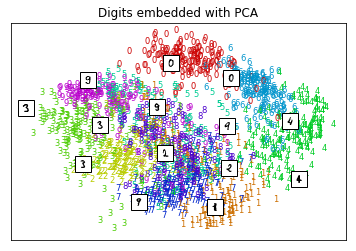

In [5]:
# PCA - to get a more realistic knn accuracy for 2d
pca = PCA(n_components=2)
X_embedp = pca.fit_transform(X)
plot_digits(X_embedp, digits, title='Digits embedded with PCA')
clf = KNN(n_neighbors=10)
clf.fit(X_embedp[:n_targets], y[:n_targets])
print "knn accuracy: %f" % clf.score(X_embedp[n_targets:], y[n_targets:])

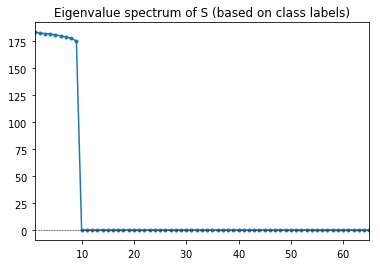

In [6]:
# check how many relevant dimensions there are
eigenvals = np.linalg.eigvalsh(S)[::-1]
plt.figure();
plt.plot(range(1, S.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, X.shape[1]+1);
plt.title('Eigenvalue spectrum of S (based on class labels)');

knn accuracy: 1.000000
similarity approximation - mse: 0.069408


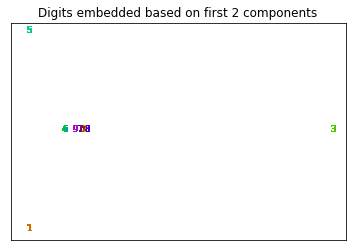

In [7]:
D, V = np.linalg.eig(S)
# regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
plot_digits(X_embed[:,:2], digits, title='Digits embedded based on first 2 components', plot_box=False)
clf = KNN(n_neighbors=10)
clf.fit(X_embed[:n_targets,:2], y[:n_targets])
print "knn accuracy: %f" % clf.score(X_embed[n_targets:,:2], y[n_targets:])
print "similarity approximation - mse: %f" % check_similarity_match(X_embed[:,:2], S)[0]

Lets first try a simple linear SimEc.

Epoch 1/25
1797/1797 [==============================] - 2s 1ms/step - loss: 0.1289
Epoch 2/25
1797/1797 [==============================] - 0s 71us/step - loss: 0.1185
Epoch 3/25
1797/1797 [==============================] - 0s 87us/step - loss: 0.1165
Epoch 4/25
1797/1797 [==============================] - 0s 79us/step - loss: 0.1155
Epoch 5/25
1797/1797 [==============================] - 0s 117us/step - loss: 0.1145
Epoch 6/25
1797/1797 [==============================] - 0s 109us/step - loss: 0.1135
Epoch 7/25
1797/1797 [==============================] - 0s 106us/step - loss: 0.1124
Epoch 8/25
1797/1797 [==============================] - 0s 95us/step - loss: 0.1115
Epoch 9/25
1797/1797 [==============================] - 0s 97us/step - loss: 0.1108
Epoch 10/25
1797/1797 [==============================] - 0s 101us/step - loss: 0.1101
Epoch 11/25
1797/1797 [==============================] - 0s 121us/step - loss: 0.1096
Epoch 12/25
1797/1797 [==============================] - 0s 103us/step

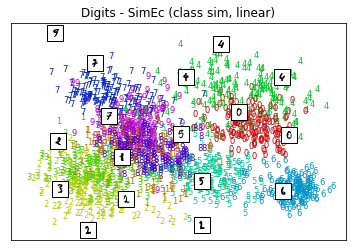

In [8]:
# similarity encoder with similarities relying on class information - linear
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, S[:,:n_targets])
X_embed = simec.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, linear)')
# of course we're overfitting here quite a bit since we used all samples for training
# even if we didn't use the corresponding similarities...but this is only a toy example anyways
clf = KNN(n_neighbors=10)
clf.fit(X_embed[:n_targets], y[:n_targets])
print "knn accuracy: %f" % clf.score(X_embed[n_targets:], y[n_targets:])
print "similarity approximation - mse: %f" % check_similarity_match(X_embed, S)[0]

Great, we already see some clusters separating from the rest! What if we add more layers?

We just need to be careful: when training the SimEc for longer, the embedding gets similar to the one based on the eigenvectors of the similarity matrix -- which is what it is supposed to, as the objective is to linearly approximate the target similarities, but in two dimensions with a bit of noise this does not give us a nice separation anymore.

5
Epoch 1/5
1797/1797 [==============================] - 0s 238us/step - loss: 0.1232
Epoch 2/5
1797/1797 [==============================] - 0s 113us/step - loss: 0.1176
Epoch 3/5
1797/1797 [==============================] - 0s 125us/step - loss: 0.1167
Epoch 4/5
1797/1797 [==============================] - 0s 131us/step - loss: 0.1157
Epoch 5/5
1797/1797 [==============================] - 0s 119us/step - loss: 0.1144
knn accuracy: 0.716437
similarity approximation - mse: 0.190231
15
Epoch 1/10
1797/1797 [==============================] - 0s 124us/step - loss: 0.1126
Epoch 2/10
1797/1797 [==============================] - 0s 114us/step - loss: 0.1107
Epoch 3/10
1797/1797 [==============================] - 0s 127us/step - loss: 0.1090
Epoch 4/10
1797/1797 [==============================] - 0s 128us/step - loss: 0.1080
Epoch 5/10
1797/1797 [==============================] - 0s 126us/step - loss: 0.1074
Epoch 6/10
1797/1797 [==============================] - 0s 112us/step - loss: 0.1072
E

1797/1797 [==============================] - 0s 115us/step - loss: 0.1046
Epoch 18/25
1797/1797 [==============================] - 0s 131us/step - loss: 0.1046
Epoch 19/25
1797/1797 [==============================] - 0s 119us/step - loss: 0.1047
Epoch 20/25
1797/1797 [==============================] - 0s 119us/step - loss: 0.1047
Epoch 21/25
1797/1797 [==============================] - 0s 120us/step - loss: 0.1046
Epoch 22/25
1797/1797 [==============================] - 0s 113us/step - loss: 0.1046
Epoch 23/25
1797/1797 [==============================] - 0s 108us/step - loss: 0.1046
Epoch 24/25
1797/1797 [==============================] - 0s 109us/step - loss: 0.1046
Epoch 25/25
1797/1797 [==============================] - 0s 126us/step - loss: 0.1047
knn accuracy: 0.811794
similarity approximation - mse: 0.070772


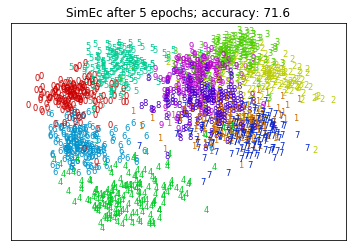

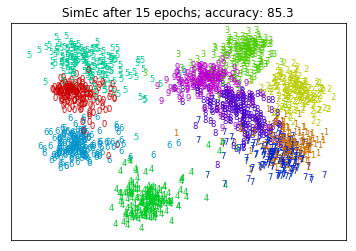

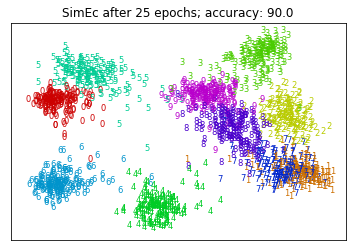

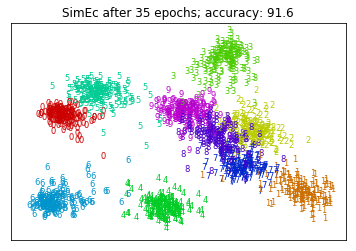

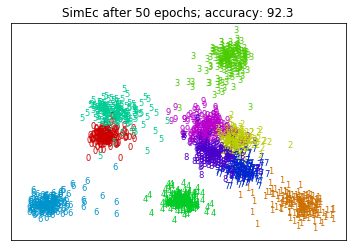

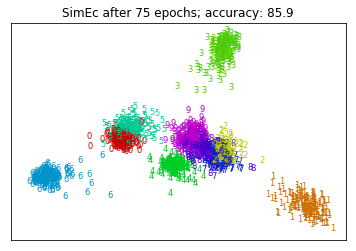

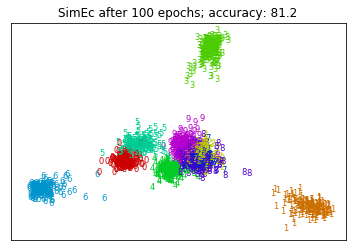

In [9]:
# similarity encoder with similarities relying on class information - 1 hidden layer
n_targets = 1000
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(100, 'tanh')], 
                          l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
e_total = 0
for e in [5, 10, 10, 10, 15, 25, 25]:
    e_total += e
    print e_total
    simec.fit(X, S[:,:n_targets], epochs=e)
    X_embed = simec.transform(X)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed[:1000], y[:1000])
    acc = clf.score(X_embed[1000:], y[1000:])
    print "knn accuracy: %f" % acc
    print "similarity approximation - mse: %f" % check_similarity_match(X_embed, S)[0]
    plot_digits(X_embed, digits, title='SimEc after %i epochs; accuracy: %.1f' % (e_total, 100*acc) , plot_box=False)

In [33]:
for e_dim in [2, 10, 25]:
    print e_dim
    #for l in [0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001, 0.]:
    #    print l
    # similarity encoder with similarities relying on class information - linear
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(100, 'tanh')], l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X, S[:,:n_targets])
    X_embed = simec.transform(X)
    # of course we're overfitting here quite a bit since we used all samples for training
    # even if we didn't use the corresponding similarities...but this is only a toy example anyways
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed[:n_targets], y[:n_targets])
    print "knn accuracy: %f" % clf.score(X_embed[n_targets:], y[n_targets:])
    print "similarity approximation - mse: %f" % check_similarity_match(X_embed, S)[0]

2
Epoch 1/25
1797/1797 [==============================] - 5s 3ms/step - loss: 0.1240
Epoch 2/25
1797/1797 [==============================] - 0s 178us/step - loss: 0.1179
Epoch 3/25
1797/1797 [==============================] - 0s 179us/step - loss: 0.1166
Epoch 4/25
1797/1797 [==============================] - 0s 180us/step - loss: 0.1155
Epoch 5/25
1797/1797 [==============================] - 0s 182us/step - loss: 0.1141
Epoch 6/25
1797/1797 [==============================] - 0s 193us/step - loss: 0.1122
Epoch 7/25
1797/1797 [==============================] - 0s 195us/step - loss: 0.1104
Epoch 8/25
1797/1797 [==============================] - 0s 186us/step - loss: 0.1090
Epoch 9/25
1797/1797 [==============================] - 0s 176us/step - loss: 0.1080
Epoch 10/25
1797/1797 [==============================] - 0s 176us/step - loss: 0.1075
Epoch 11/25
1797/1797 [==============================] - 0s 185us/step - loss: 0.1073
Epoch 12/25
1797/1797 [==============================] - 0s 196

## MNIST Dataset
Embedding the regular 28x28 pixel MNIST digits

In [10]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
n_targets = 1000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
# scale
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

In [11]:
# compute similarity matrix based on class labels
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
Y = np.tile(y_test, (len(y_test), 1))
S_test = center_K(np.array(Y==Y.T, dtype=int))

In [12]:
clf = KNN(n_neighbors=10)
clf.fit(X, y)
print "knn accuracy: %f" % clf.score(X_test, y_test)

knn accuracy: 0.932000


knn accuracy: 0.418000
similarity approximation - mse: 40.005883 (38.246017)


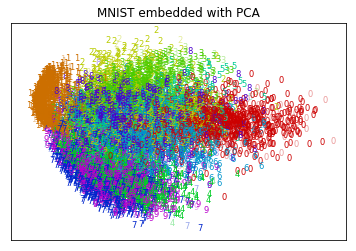

In [13]:
# PCA - to get a more realistic knn accuracy for 2d
e_pca = PCA(n_components=2)
X_embed = e_pca.fit_transform(X)
X_embed_test = e_pca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST embedded with PCA')
clf = KNN(n_neighbors=10)
clf.fit(X_embed, y)
print "knn accuracy: %f" % clf.score(X_embed_test, y_test)

#### "Kernel PCA" and Ridge Regression
To get an idea of how a perfect similarity preserving embedding would look like when computing similarities from class labels, we can embed the data by performing an eigendecomposition of the similarity matrix (i.e. performing kernel PCA). However, since in a real setting we would be unable to compute the similarities of the test samples to the training samples (since we don't know their class labels), to map the test samples into the embedding space we additionally need to train a (ridge) regression model to map from the original input space to the embedding space.

similarity approximation  2D - mse: 0.066420
similarity approximation  5D - mse: 0.035617
similarity approximation  7D - mse: 0.016659
similarity approximation 10D - mse: 0.000000
similarity approximation 25D - mse: 0.000000


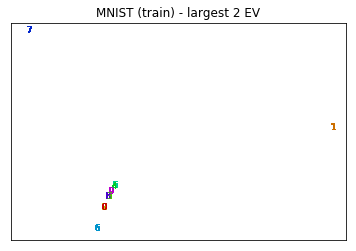

In [14]:
D, V = np.linalg.eig(S)
# as a comparison: regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
plot_mnist(X_embed[:,:2], y, title='MNIST (train) - largest 2 EV')
print "similarity approximation  2D - mse: %f" % check_similarity_match(X_embed[:,:2], S)[0]
print "similarity approximation  5D - mse: %f" % check_similarity_match(X_embed[:,:5], S)[0]
print "similarity approximation  7D - mse: %f" % check_similarity_match(X_embed[:,:7], S)[0]
print "similarity approximation 10D - mse: %f" % check_similarity_match(X_embed[:,:10], S)[0]
print "similarity approximation 25D - mse: %f" % check_similarity_match(X_embed[:,:25], S)[0]

In [15]:
# ridge reg
for e_dim in [2, 5, 7, 10, 25]:
    model = Ridge()
    model.fit(X, X_embed[:,:e_dim])
    X_embed_r = model.predict(X)
    X_embed_test = model.predict(X_test)
    print "similarity approximation %i D - mse: %f (%f)" % (e_dim, check_similarity_match(X_embed_r, S)[0], check_similarity_match(X_embed_test, S_test)[0])
    # train knn with original kPCA embedding
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed[:,:e_dim], y)
    print "knn accuracy (trained on kPCA embedding): %f" % clf.score(X_embed_test, y_test)
    # and with ridge regression embedding of the training data
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed_r, y)
    acc = clf.score(X_embed_test, y_test)
    print "knn accuracy (trained on RR embedding): %f" % acc
    if e_dim == 2: plot_mnist(X_embed_r, y, X_embed_test, y_test, title='MNIST - Ridge Regression (accuracy: %.1f)' % 100*acc)

similarity approximation 2 D - mse: 0.077358 (0.079692)
knn accuracy (trained on kPCA embedding): 0.328000
knn accuracy (trained on RR embedding): 0.376000


TypeError: 'numpy.float64' object cannot be interpreted as an index

#### Supervised SimEc
Try SimEcs with a varying number of non-linear hidden layers to approximate class-based similarities in the embedding.

In [ ]:
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.00001, l2_reg_out=0.000001, s_ll_reg=0.5, 
                          S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0005))
e_total = 0
for e in [2, 3, 5, 10, 15, 15, 25, 25]:
    e_total += e
    print e_total
    simec.fit(X, S[:,:n_targets], epochs=e)
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed, y)
    acc = clf.score(X_embed_test, y_test)
    print "knn accuracy: %f" % acc
    print "similarity approximation - mse: %f (%f)" % (check_similarity_match(X_embed, S)[0], check_similarity_match(X_embed_test, S_test)[0])
    plot_mnist(X_embed, y, X_embed_test, y_test, title='SimEc (0 h.l.) after %i epochs - accuracy: %.1f' % (e_total, 100*acc))
    if savefigs: plt.savefig('fig_class_mnist_simec0_%i.png' % e_total, dpi=300)

In [ ]:
# class labels - 1 hidden layer
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(500, 'tanh')], l2_reg=0.00001, 
                          l2_reg_emb=0.00001, l2_reg_out=0.000001, s_ll_reg=0.75, 
                          S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.001))
e_total = 0
for e in [2, 3, 5, 10, 15, 15, 25, 25]:
    e_total += e
    print e_total
    simec.fit(X, S[:,:n_targets], epochs=e)
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed, y)
    acc = clf.score(X_embed_test, y_test)
    print "knn accuracy: %f" % acc
    print "similarity approximation - mse: %f (%f)" % (check_similarity_match(X_embed, S)[0], check_similarity_match(X_embed_test, S_test)[0])
    plot_mnist(X_embed, y, X_embed_test, y_test, title='SimEc (0 h.l.) after %i epochs - accuracy: %.1f' % (e_total, 100*acc))
    if savefigs: plt.savefig('fig_class_mnist_simec1_%i.png' % e_total, dpi=300)

Epoch 1/25
8000/8000 [==============================] - 7s - loss: 0.1826     
Epoch 2/25
8000/8000 [==============================] - 6s - loss: 0.1715     
Epoch 3/25
8000/8000 [==============================] - 6s - loss: 0.1664     
Epoch 4/25
8000/8000 [==============================] - 7s - loss: 0.1646     
Epoch 5/25
8000/8000 [==============================] - 7s - loss: 0.1633     
Epoch 6/25
8000/8000 [==============================] - 6s - loss: 0.1621     
Epoch 7/25
8000/8000 [==============================] - 6s - loss: 0.1606     
Epoch 8/25
8000/8000 [==============================] - 6s - loss: 0.1588     
Epoch 9/25
8000/8000 [==============================] - 6s - loss: 0.1566     
Epoch 10/25
8000/8000 [==============================] - 6s - loss: 0.1538     
Epoch 11/25
8000/8000 [==============================] - 6s - loss: 0.1505     
Epoch 12/25
8000/8000 [==============================] - 6s - loss: 0.1470     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

knn accuracy: 0.552500


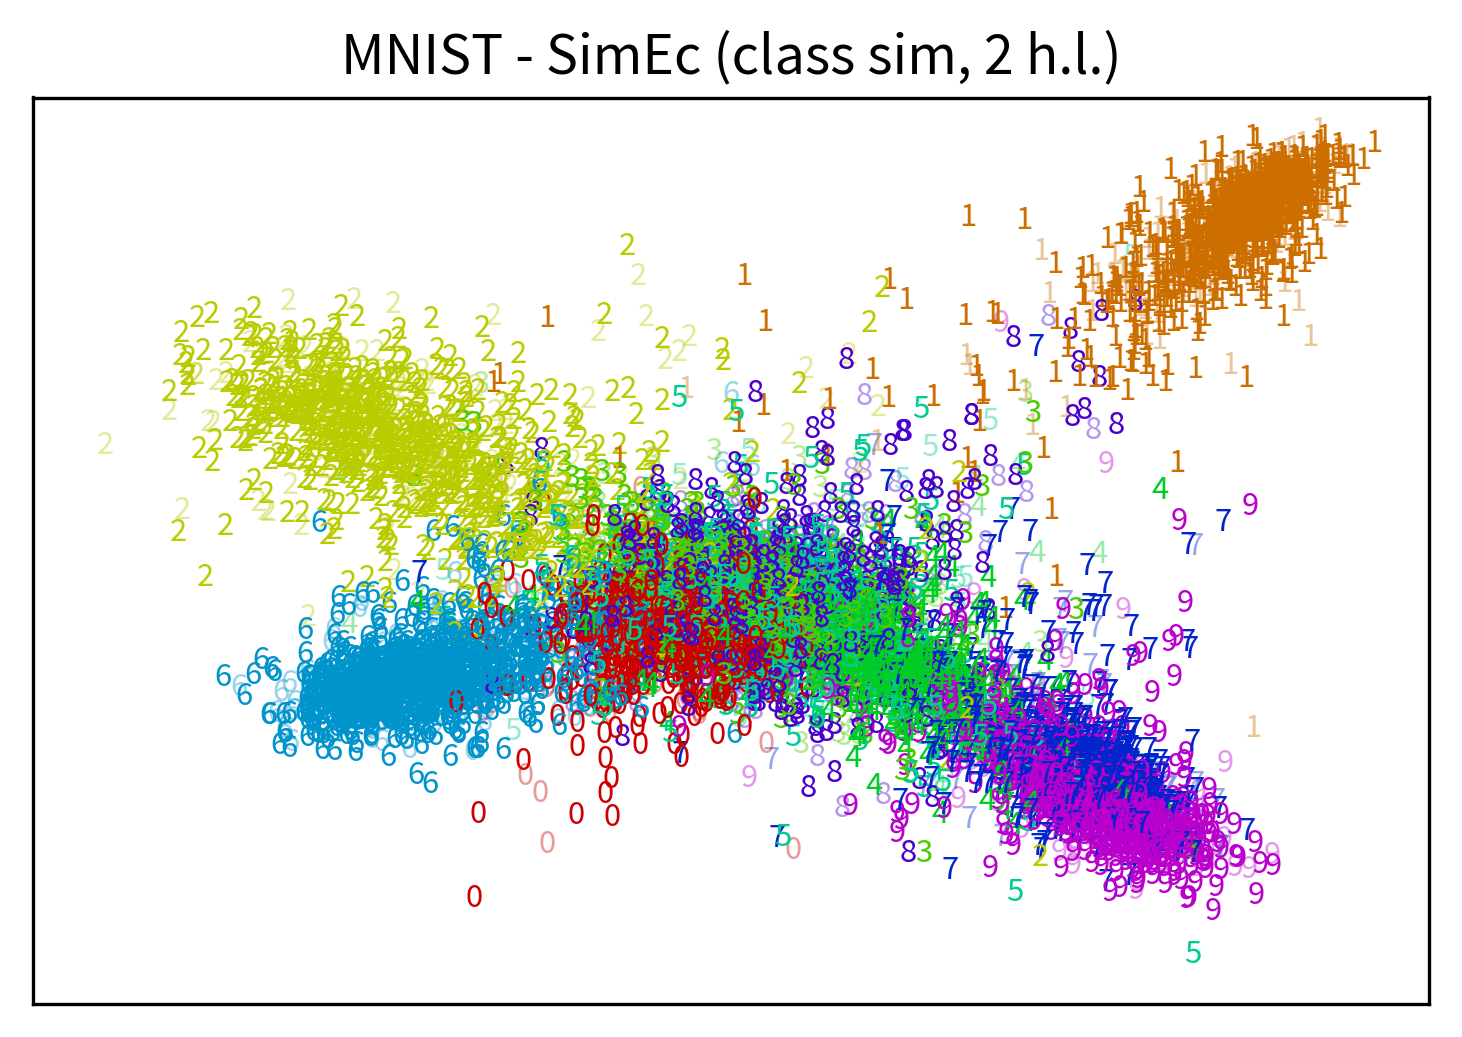

In [23]:
# class labels - 2 hidden layers
e_csimenc = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(25, 'tanh'), (10, 'tanh')], s_ll_reg=1., S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0005))
e_csimenc.fit(X, S[:,:n_targets])
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 2 h.l.)')
clf = KNN(n_neighbors=10)
clf.fit(X_embed, y)
print "knn accuracy: %f" % clf.score(X_embed_test, y_test)

2


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 7s - loss: 0.1802     
Epoch 2/25
8000/8000 [==============================] - 6s - loss: 0.1702     
Epoch 3/25
8000/8000 [==============================] - 6s - loss: 0.1653     
Epoch 4/25
8000/8000 [==============================] - 5s - loss: 0.1635     
Epoch 5/25
8000/8000 [==============================] - 5s - loss: 0.1623     
Epoch 6/25
8000/8000 [==============================] - 6s - loss: 0.1611     
Epoch 7/25
8000/8000 [==============================] - 5s - loss: 0.1596     
Epoch 8/25
8000/8000 [==============================] - 5s - loss: 0.1578     
Epoch 9/25
8000/8000 [==============================] - 5s - loss: 0.1554     
Epoch 10/25
8000/8000 [==============================] - 5s - loss: 0.1525     
Epoch 11/25
8000/8000 [==============================] - 5s - loss: 0.1491     
Epoch 12/25
8000/8000 [==============================] - 5s - loss: 0.1458     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.418000; acc simec: 0.477000
4


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 6s - loss: 0.1790     
Epoch 2/25
8000/8000 [==============================] - 5s - loss: 0.1639     
Epoch 3/25
8000/8000 [==============================] - 5s - loss: 0.1538     
Epoch 4/25
8000/8000 [==============================] - 5s - loss: 0.1482     
Epoch 5/25
8000/8000 [==============================] - 5s - loss: 0.1448     
Epoch 6/25
8000/8000 [==============================] - 5s - loss: 0.1417     
Epoch 7/25
8000/8000 [==============================] - 5s - loss: 0.1379     
Epoch 8/25
8000/8000 [==============================] - 5s - loss: 0.1335     - ETA: 1s - loss: 0 - E
Epoch 9/25
8000/8000 [==============================] - 5s - loss: 0.1287     
Epoch 10/25
8000/8000 [==============================] - 7s - loss: 0.1238     
Epoch 11/25
8000/8000 [==============================] - 7s - loss: 0.1191     
Epoch 12/25
8000/8000 [==============================] - 6s - loss: 0.1148     
Epoch 13/25
8000/8000 [===

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.632500; acc simec: 0.741500
6


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 6s - loss: 0.1778     - ETA:
Epoch 2/25
8000/8000 [==============================] - 5s - loss: 0.1590     
Epoch 3/25
8000/8000 [==============================] - 5s - loss: 0.1472     
Epoch 4/25
8000/8000 [==============================] - 5s - loss: 0.1400      - ETA: 0s - loss: 0.1
Epoch 5/25
8000/8000 [==============================] - 5s - loss: 0.1342     
Epoch 6/25
8000/8000 [==============================] - 5s - loss: 0.1272     
Epoch 7/25
8000/8000 [==============================] - 5s - loss: 0.1180     - ETA: 0s - loss: 
Epoch 8/25
8000/8000 [==============================] - 5s - loss: 0.1075     
Epoch 9/25
8000/8000 [==============================] - 5s - loss: 0.0979     
Epoch 10/25
8000/8000 [==============================] - 5s - loss: 0.0898     
Epoch 11/25
8000/8000 [==============================] - 5s - loss: 0.0837     
Epoch 12/25
8000/8000 [==============================] - 5s - loss: 0.0792     
Epo

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.804000; acc simec: 0.806000
10


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 6s - loss: 0.1750     
Epoch 2/25
8000/8000 [==============================] - 5s - loss: 0.1521     
Epoch 3/25
8000/8000 [==============================] - 5s - loss: 0.1400     
Epoch 4/25
8000/8000 [==============================] - 5s - loss: 0.1291     
Epoch 5/25
8000/8000 [==============================] - 5s - loss: 0.1165     
Epoch 6/25
8000/8000 [==============================] - 5s - loss: 0.1030     
Epoch 7/25
8000/8000 [==============================] - 5s - loss: 0.0888     
Epoch 8/25
8000/8000 [==============================] - 5s - loss: 0.0749     
Epoch 9/25
8000/8000 [==============================] - 5s - loss: 0.0630     
Epoch 10/25
8000/8000 [==============================] - 6s - loss: 0.0553     
Epoch 11/25
8000/8000 [==============================] - 6s - loss: 0.0501     
Epoch 12/25
8000/8000 [==============================] - 5s - loss: 0.0456     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.900500; acc simec: 0.891500
15


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 7s - loss: 0.1726     
Epoch 2/25
8000/8000 [==============================] - 5s - loss: 0.1457     
Epoch 3/25
8000/8000 [==============================] - 5s - loss: 0.1320     
Epoch 4/25
8000/8000 [==============================] - 6s - loss: 0.1188     
Epoch 5/25
8000/8000 [==============================] - 5s - loss: 0.1019     
Epoch 6/25
8000/8000 [==============================] - 5s - loss: 0.0824     
Epoch 7/25
8000/8000 [==============================] - 6s - loss: 0.0642     
Epoch 8/25
8000/8000 [==============================] - 5s - loss: 0.0502     
Epoch 9/25
8000/8000 [==============================] - 6s - loss: 0.0421     
Epoch 10/25
8000/8000 [==============================] - 5s - loss: 0.0387     
Epoch 11/25
8000/8000 [==============================] - 5s - loss: 0.0375     
Epoch 12/25
8000/8000 [==============================] - 5s - loss: 0.0368     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.922000; acc simec: 0.895500
25


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 7s - loss: 0.1712     
Epoch 2/25
8000/8000 [==============================] - 6s - loss: 0.1397     
Epoch 3/25
8000/8000 [==============================] - 6s - loss: 0.1244     
Epoch 4/25
8000/8000 [==============================] - 6s - loss: 0.1084     
Epoch 5/25
8000/8000 [==============================] - 6s - loss: 0.0882     
Epoch 6/25
8000/8000 [==============================] - 6s - loss: 0.0662     
Epoch 7/25
8000/8000 [==============================] - 6s - loss: 0.0496     
Epoch 8/25
8000/8000 [==============================] - 6s - loss: 0.0414     
Epoch 9/25
8000/8000 [==============================] - 6s - loss: 0.0385     
Epoch 10/25
8000/8000 [==============================] - 6s - loss: 0.0373     
Epoch 11/25
8000/8000 [==============================] - 6s - loss: 0.0363     
Epoch 12/25
8000/8000 [==============================] - 6s - loss: 0.0355     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.936500; acc simec: 0.904000
50


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 8s - loss: 0.1692     
Epoch 2/25
8000/8000 [==============================] - 7s - loss: 0.1335     
Epoch 3/25
8000/8000 [==============================] - 7s - loss: 0.1145     
Epoch 4/25
8000/8000 [==============================] - 7s - loss: 0.0879     
Epoch 5/25
8000/8000 [==============================] - 7s - loss: 0.0605     
Epoch 6/25
8000/8000 [==============================] - 7s - loss: 0.0464     
Epoch 7/25
8000/8000 [==============================] - 7s - loss: 0.0422     
Epoch 8/25
8000/8000 [==============================] - 7s - loss: 0.0405     
Epoch 9/25
8000/8000 [==============================] - 7s - loss: 0.0392     
Epoch 10/25
8000/8000 [==============================] - 7s - loss: 0.0380     
Epoch 11/25
8000/8000 [==============================] - 7s - loss: 0.0368     
Epoch 12/25
8000/8000 [==============================] - 7s - loss: 0.0357     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.942000; acc simec: 0.922500
100


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
8000/8000 [==============================] - 10s - loss: 0.1716    
Epoch 2/25
8000/8000 [==============================] - 9s - loss: 0.1354     
Epoch 3/25
8000/8000 [==============================] - 9s - loss: 0.1087     
Epoch 4/25
8000/8000 [==============================] - 9s - loss: 0.0719     
Epoch 5/25
8000/8000 [==============================] - 9s - loss: 0.0519     
Epoch 6/25
8000/8000 [==============================] - 9s - loss: 0.0474     
Epoch 7/25
8000/8000 [==============================] - 9s - loss: 0.0453     
Epoch 8/25
8000/8000 [==============================] - 9s - loss: 0.0434     
Epoch 9/25
8000/8000 [==============================] - 9s - loss: 0.0417     
Epoch 10/25
8000/8000 [==============================] - 9s - loss: 0.0400     
Epoch 11/25
8000/8000 [==============================] - 9s - loss: 0.0385     
Epoch 12/25
8000/8000 [==============================] - 8s - loss: 0.0370     
Epoch 13/25
8000/8000 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc pca: 0.936000; acc simec: 0.931000


Text(0.5,1,u'kNN Accuracy')

([<matplotlib.axis.XTick at 0x19f902b90>,
 <a list of 8 Text xticklabel objects>)

Text(0.5,0,u'Number of Embedding Dimensions')

Text(0,0.5,u'Accuracy')

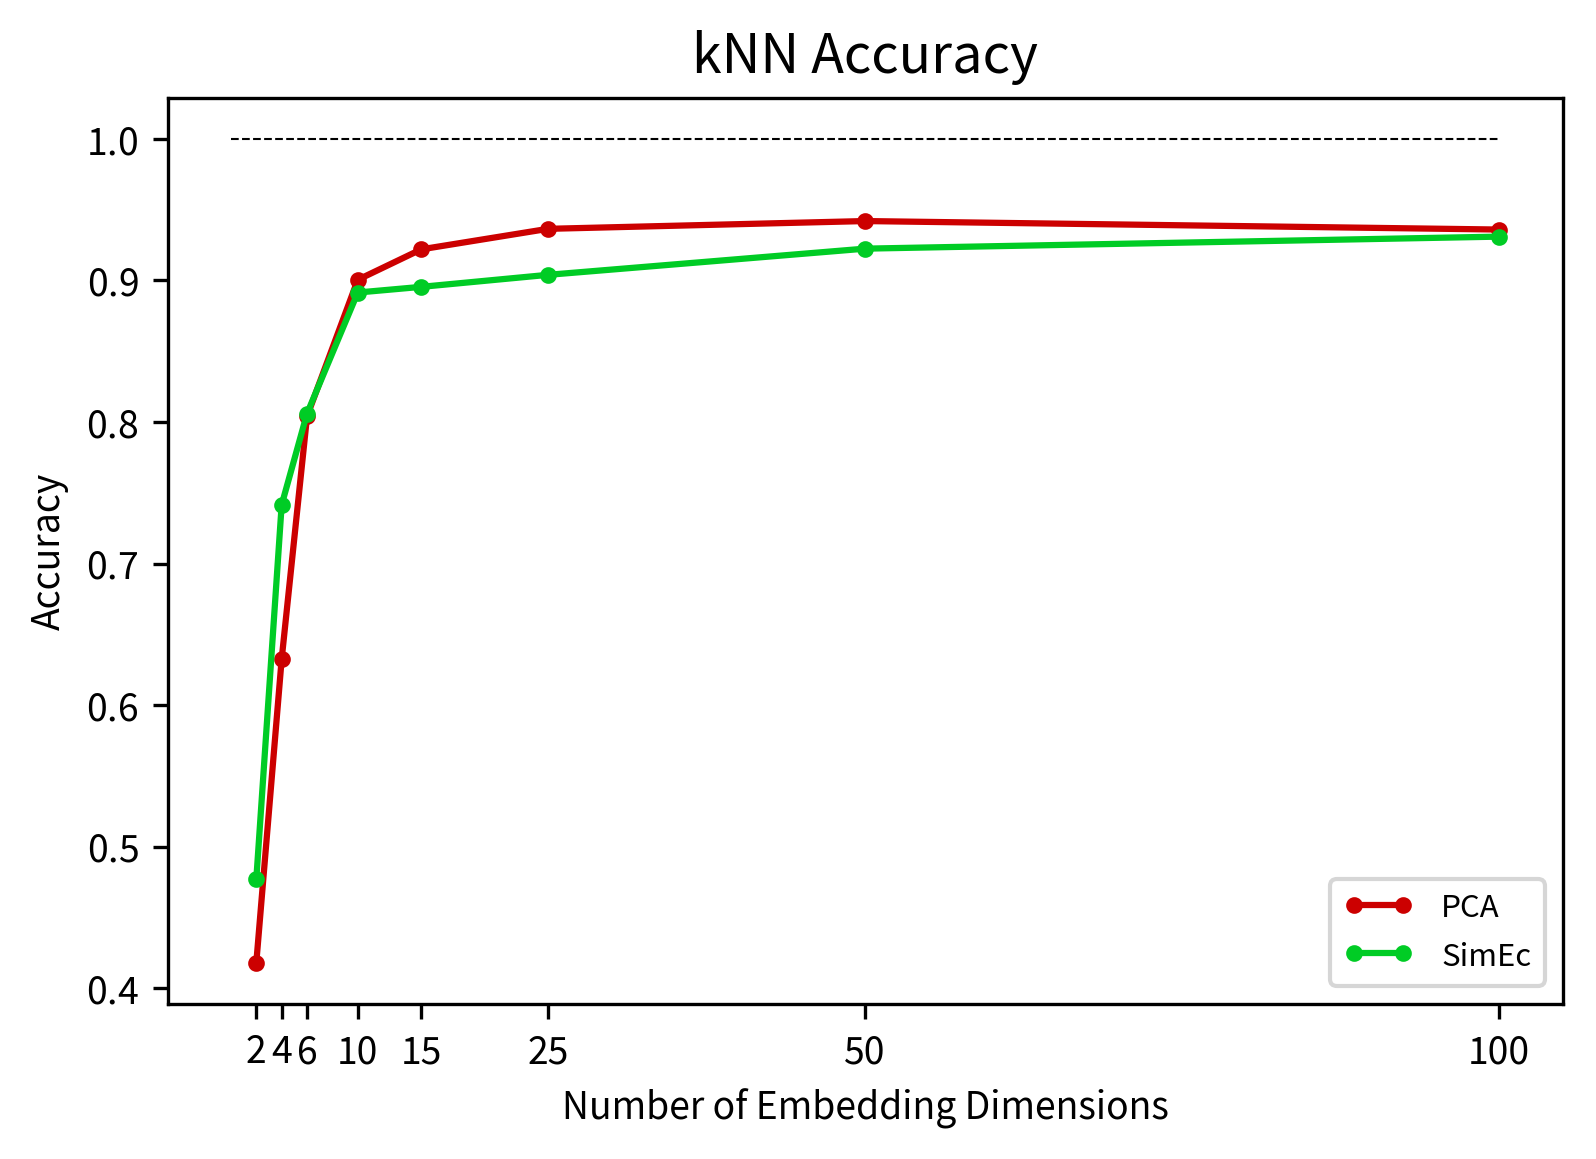

In [35]:
colors = get_colors(10)
acc_pca, acc_simec = [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print e_dim
    e_pca = PCA(n_components=e_dim)
    X_embedp = e_pca.fit_transform(X)
    X_embedp_test = e_pca.transform(X_test)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embedp, y)
    acc_pca.append(clf.score(X_embedp_test, y_test))
    e_csimenc = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(max(10, e_dim), 'tanh')], 
                                  s_ll_reg=1., S_ll=S[:n_targets,:n_targets], 
                                  opt=keras.optimizers.Adamax(lr=0.0005))
    e_csimenc.fit(X, S[:,:n_targets])
    X_embed = e_csimenc.transform(X)
    X_embed_test = e_csimenc.transform(X_test)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed, y)
    acc_simec.append(clf.score(X_embed_test, y_test))
    print "acc pca: %f; acc simec: %f" % (acc_pca[-1], acc_simec[-1])
plt.figure();
plt.plot(e_dims, acc_pca, '-o', markersize=3, c=colors[0], label='PCA');
plt.plot(e_dims, acc_simec, '-o', markersize=3, c=colors[4], label='SimEc');
plt.legend(loc=0);
plt.title('kNN Accuracy');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions')
plt.ylabel('Accuracy')

In [69]:
# similarity encoder with similarities relying on class information - linear
for e_dim in [2, 5, 10]:
    print e_dim
    for l in [0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001, 0.]:
        print l
        simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(500, 'tanh')], l2_reg=0.00001, l2_reg_emb=0.00001, l2_reg_out=0.000001, s_ll_reg=l, S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0005))
        simec.fit(X, S[:,:n_targets], epochs=30)
        X_embed = simec.transform(X)
        X_embed_test = simec.transform(X_test)
        mse = check_similarity_match(X_embed, S)[0]
        mse_t = check_similarity_match(X_embed_test, S_test)[0]
        print "similarity approximation - mse: %f (%f)" % (mse, mse_t)

2
0.0
Epoch 1/30
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0906
Epoch 2/30
8000/8000 [==============================] - 2s 256us/step - loss: 0.0805
Epoch 3/30
8000/8000 [==============================] - 2s 256us/step - loss: 0.0772
Epoch 4/30
8000/8000 [==============================] - 2s 249us/step - loss: 0.0763
Epoch 5/30
8000/8000 [==============================] - 2s 260us/step - loss: 0.0755
Epoch 6/30
8000/8000 [==============================] - 2s 254us/step - loss: 0.0748
Epoch 7/30
8000/8000 [==============================] - 2s 249us/step - loss: 0.0742
Epoch 8/30
8000/8000 [==============================] - 2s 257us/step - loss: 0.0736
Epoch 9/30
8000/8000 [==============================] - 2s 260us/step - loss: 0.0730
Epoch 10/30
8000/8000 [==============================] - 2s 255us/step - loss: 0.0725
Epoch 11/30
8000/8000 [==============================] - 2s 253us/step - loss: 0.0720
Epoch 12/30
8000/8000 [==============================] - 2

8000/8000 [==============================] - 2s 258us/step - loss: 0.0532
Epoch 8/30
8000/8000 [==============================] - 2s 263us/step - loss: 0.0524
Epoch 9/30
8000/8000 [==============================] - 2s 256us/step - loss: 0.0515
Epoch 10/30
8000/8000 [==============================] - 2s 260us/step - loss: 0.0506
Epoch 11/30
8000/8000 [==============================] - 2s 254us/step - loss: 0.0497
Epoch 12/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.0489
Epoch 13/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.0482
Epoch 14/30
8000/8000 [==============================] - 2s 252us/step - loss: 0.0475
Epoch 15/30
8000/8000 [==============================] - 2s 256us/step - loss: 0.0469
Epoch 16/30
8000/8000 [==============================] - 2s 256us/step - loss: 0.0463
Epoch 17/30
8000/8000 [==============================] - 2s 266us/step - loss: 0.0458
Epoch 18/30
8000/8000 [==============================] - 2s 256us/st

8000/8000 [==============================] - 2s 264us/step - loss: 0.0273
Epoch 14/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.0257
Epoch 15/30
8000/8000 [==============================] - 2s 254us/step - loss: 0.0243
Epoch 16/30
8000/8000 [==============================] - 2s 258us/step - loss: 0.0230
Epoch 17/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.0218
Epoch 18/30
8000/8000 [==============================] - 2s 254us/step - loss: 0.0208
Epoch 19/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.0199
Epoch 20/30
8000/8000 [==============================] - 2s 262us/step - loss: 0.0191
Epoch 21/30
8000/8000 [==============================] - 2s 263us/step - loss: 0.0184
Epoch 22/30
8000/8000 [==============================] - 2s 260us/step - loss: 0.0178
Epoch 23/30
8000/8000 [==============================] - 2s 255us/step - loss: 0.0172
Epoch 24/30
8000/8000 [==============================] - 2s 268us/

## 20 Newsgroups
To show that SimEc embeddings can also be computed for other types of data, we do some further experiments with the 20 newsgroups dataset. We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting (see also `http://scikit-learn.org/stable/datasets/twenty_newsgroups.html`). The posts are transformed into very high dimensional tf-idf vectors used as input to the SimEc and to compute the linear kernel matrix.

In [36]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts (if the text contains more than 3 words)
textdict = {i: t for i, t in enumerate(newsgroups_train.data) if len(t.split()) > 3}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data)) if len(t.split()) > 3})
train_ids = [i for i in range(len(newsgroups_train.data)) if i in textdict]
test_ids = [i for i in range(len(newsgroups_train.data), len(textdict)) if i in textdict]
print "%i training and %i test samples" % (len(train_ids), len(test_ids))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)
targets = np.hstack([newsgroups_train.target,newsgroups_test.target])
y = targets[train_ids]
y_test = targets[test_ids]
n_targets = 1000
target_names = newsgroups_train.target_names

3959 training and 2359 test samples
45813 features


In [37]:
clf = KNN(n_neighbors=10)
clf.fit(X, y)
print "knn accuracy: %f" % clf.score(X_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

knn accuracy: 0.237813


#### Linear SimEc
Again, linear kPCA and SimEc give the same solution (up to a rotation). Btw, here we can't use regular PCA as the covariance matrix would be very high dimensional and poorly estimated due to the small amount of samples.

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

knn accuracy: 0.323866


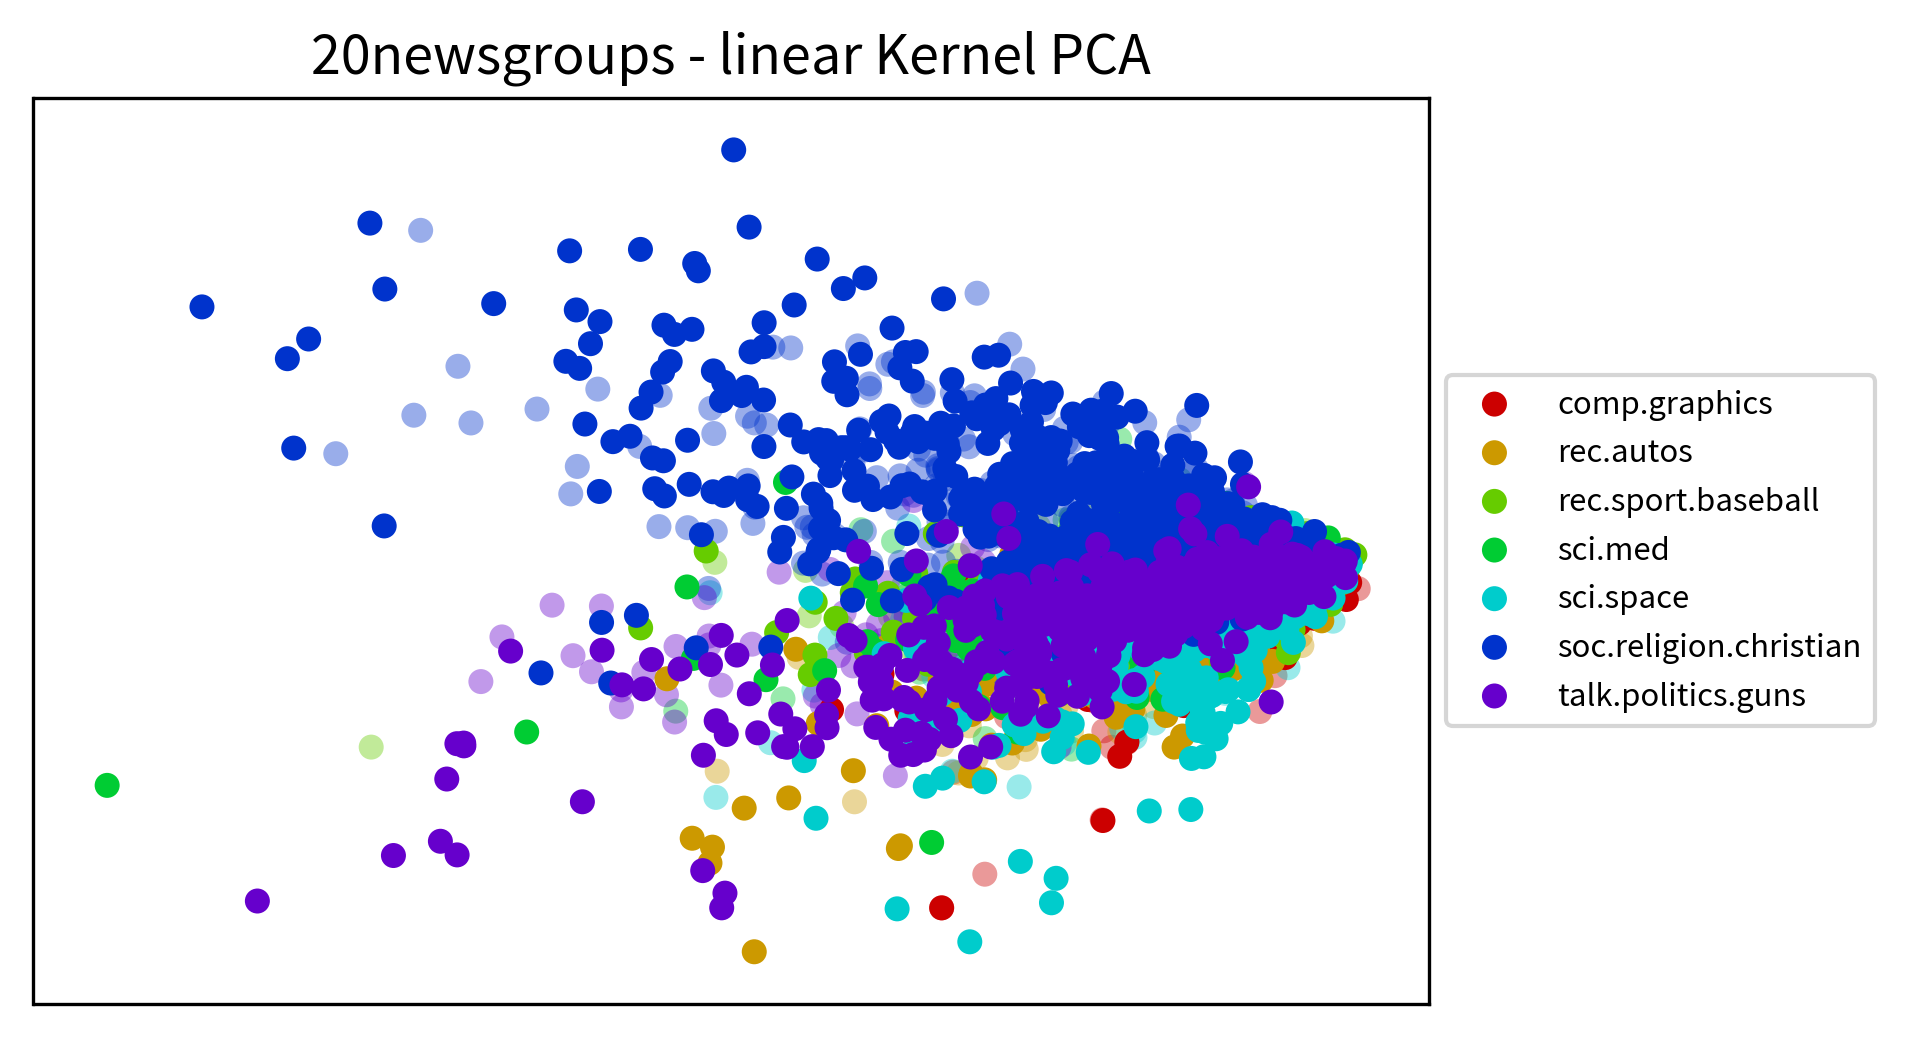

In [38]:
# linear kPCA
e_lkpca = KernelPCA(n_components=2, kernel='linear')
X_embed = e_lkpca.fit_transform(X)
X_embed_test = e_lkpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20newsgroups - linear Kernel PCA', legend=True)
clf = KNN(n_neighbors=10)
clf.fit(X_embed, y)
print "knn accuracy: %f" % clf.score(X_embed_test, y_test)

#### Supervised SimEc
Non-linear SimEc to create a 2d embedding in which the class-based similarities are retained.

Epoch 1/25
3959/3959 [==============================] - 11s - loss: 0.1706    
Epoch 2/25
3959/3959 [==============================] - 10s - loss: 0.1460    
Epoch 3/25
3959/3959 [==============================] - 10s - loss: 0.1340    
Epoch 4/25
3959/3959 [==============================] - 10s - loss: 0.1310    
Epoch 5/25
3959/3959 [==============================] - 10s - loss: 0.1306    
Epoch 6/25
3959/3959 [==============================] - 10s - loss: 0.1301    
Epoch 7/25
3959/3959 [==============================] - 10s - loss: 0.1293    
Epoch 8/25
3959/3959 [==============================] - 10s - loss: 0.1290    
Epoch 9/25
3959/3959 [==============================] - 10s - loss: 0.1290    
Epoch 10/25
3959/3959 [==============================] - 10s - loss: 0.1288    
Epoch 11/25
3959/3959 [==============================] - 10s - loss: 0.1285    
Epoch 12/25
3959/3959 [==============================] - 10s - loss: 0.1282    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

knn accuracy: 0.487919


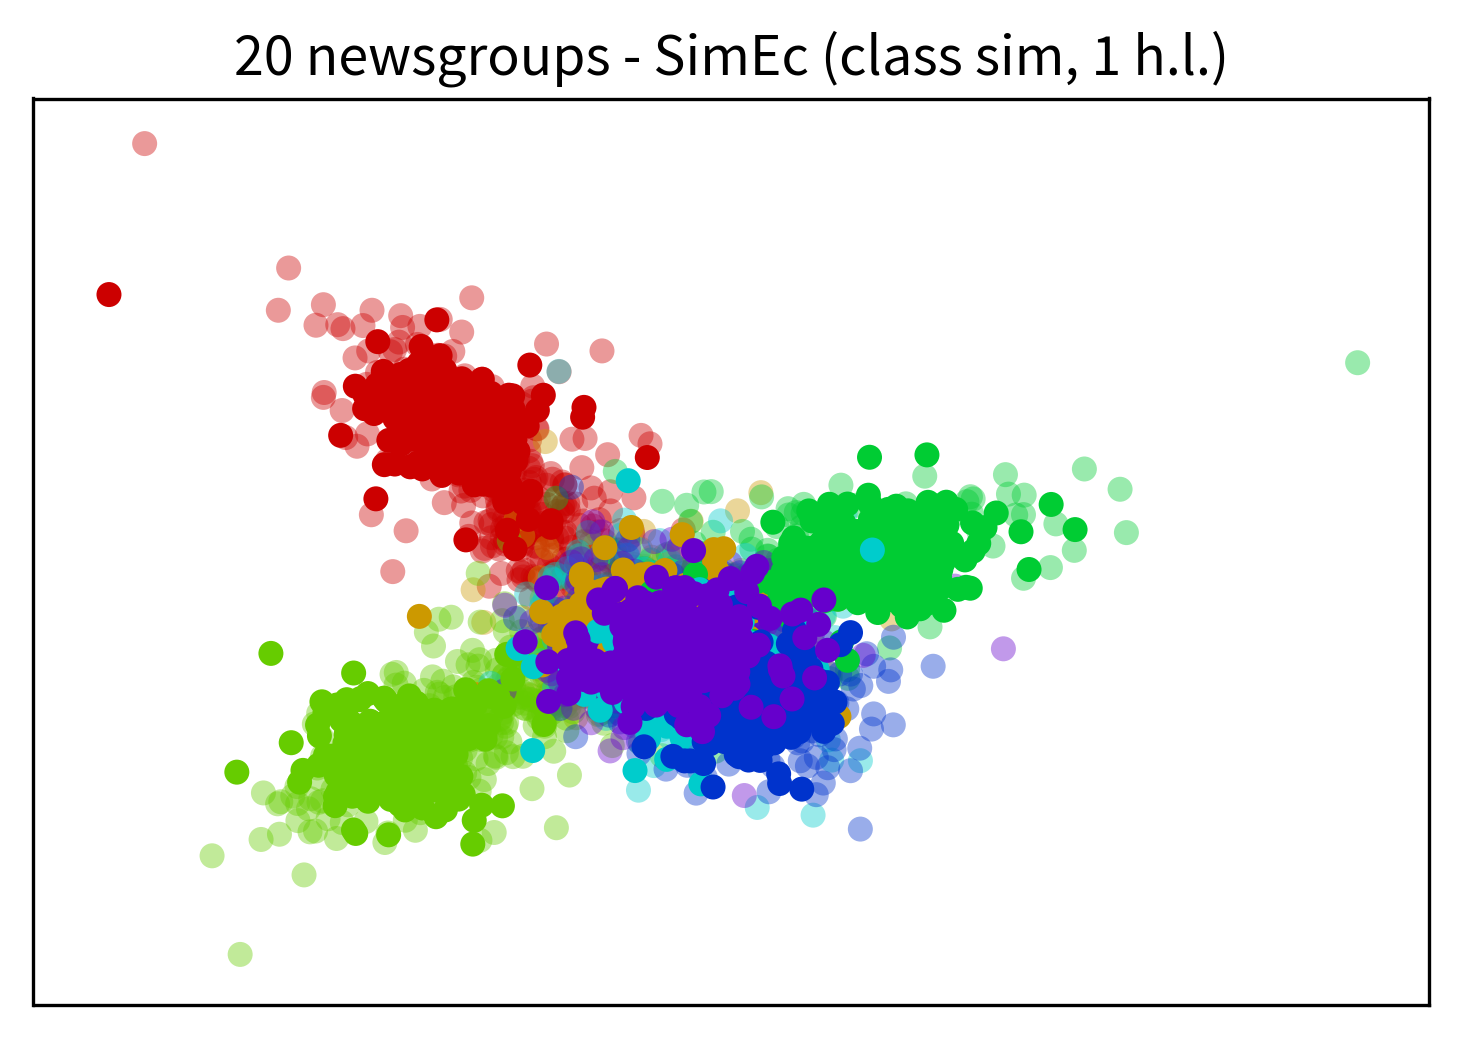

In [39]:
# compute label based simmat
n_targets = 2000
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
# project to 2d with similarity encoder
e_lsimenc = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(20, 'tanh')],
                              sparse_inputs=True, s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets])
e_lsimenc.fit(X, S[:,:n_targets])
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20 newsgroups - SimEc (class sim, 1 h.l.)')
clf = KNN(n_neighbors=10)
clf.fit(X_embed, y)
print "knn accuracy: %f" % clf.score(X_embed_test, y_test)

2


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 11s - loss: 0.1679    
Epoch 2/25
3959/3959 [==============================] - 10s - loss: 0.1459    
Epoch 3/25
3959/3959 [==============================] - 11s - loss: 0.1346    
Epoch 4/25
3959/3959 [==============================] - 10s - loss: 0.1311    
Epoch 5/25
3959/3959 [==============================] - 10s - loss: 0.1305    
Epoch 6/25
3959/3959 [==============================] - 10s - loss: 0.1297    
Epoch 7/25
3959/3959 [==============================] - 10s - loss: 0.1292    
Epoch 8/25
3959/3959 [==============================] - 10s - loss: 0.1287    
Epoch 9/25
3959/3959 [==============================] - 10s - loss: 0.1285    
Epoch 10/25
3959/3959 [==============================] - 10s - loss: 0.1283    
Epoch 11/25
3959/3959 [==============================] - 10s - loss: 0.1279    
Epoch 12/25
3959/3959 [==============================] - 10s - loss: 0.1277    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.323866; acc simec: 0.458669
4


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 13s - loss: 0.1545    
Epoch 2/25
3959/3959 [==============================] - 10s - loss: 0.0991    
Epoch 3/25
3959/3959 [==============================] - 10s - loss: 0.0795    
Epoch 4/25
3959/3959 [==============================] - 10s - loss: 0.0749    
Epoch 5/25
3959/3959 [==============================] - 10s - loss: 0.0736    
Epoch 6/25
3959/3959 [==============================] - 10s - loss: 0.0733    
Epoch 7/25
3959/3959 [==============================] - 10s - loss: 0.0728    
Epoch 8/25
3959/3959 [==============================] - 10s - loss: 0.0725    
Epoch 9/25
3959/3959 [==============================] - 10s - loss: 0.0721    
Epoch 10/25
3959/3959 [==============================] - 10s - loss: 0.0719    
Epoch 11/25
3959/3959 [==============================] - 11s - loss: 0.0717    
Epoch 12/25
3959/3959 [==============================] - 10s - loss: 0.0714    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.507842; acc simec: 0.632895
6


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 12s - loss: 0.1470    
Epoch 2/25
3959/3959 [==============================] - 10s - loss: 0.0796    
Epoch 3/25
3959/3959 [==============================] - 10s - loss: 0.0366    
Epoch 4/25
3959/3959 [==============================] - 10s - loss: 0.0240    
Epoch 5/25
3959/3959 [==============================] - 10s - loss: 0.0199    
Epoch 6/25
3959/3959 [==============================] - 10s - loss: 0.0184    
Epoch 7/25
3959/3959 [==============================] - 10s - loss: 0.0179    
Epoch 8/25
3959/3959 [==============================] - 10s - loss: 0.0176    
Epoch 9/25
3959/3959 [==============================] - 10s - loss: 0.0170    
Epoch 10/25
3959/3959 [==============================] - 10s - loss: 0.0167    
Epoch 11/25
3959/3959 [==============================] - 10s - loss: 0.0166    
Epoch 12/25
3959/3959 [==============================] - 10s - loss: 0.0165    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.621026; acc simec: 0.831708
10


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 12s - loss: 0.1292    
Epoch 2/25
3959/3959 [==============================] - 10s - loss: 0.0449    
Epoch 3/25
3959/3959 [==============================] - 10s - loss: 0.0266    
Epoch 4/25
3959/3959 [==============================] - 11s - loss: 0.0205    
Epoch 5/25
3959/3959 [==============================] - 10s - loss: 0.0185    
Epoch 6/25
3959/3959 [==============================] - 10s - loss: 0.0179    
Epoch 7/25
3959/3959 [==============================] - 10s - loss: 0.0178    
Epoch 8/25
3959/3959 [==============================] - 10s - loss: 0.0175    
Epoch 9/25
3959/3959 [==============================] - 10s - loss: 0.0171    
Epoch 10/25
3959/3959 [==============================] - 10s - loss: 0.0167    
Epoch 11/25
3959/3959 [==============================] - 10s - loss: 0.0166    
Epoch 12/25
3959/3959 [==============================] - 10s - loss: 0.0166    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.717253; acc simec: 0.829589
15


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 12s - loss: 0.1191    
Epoch 2/25
3959/3959 [==============================] - 10s - loss: 0.0417    
Epoch 3/25
3959/3959 [==============================] - 10s - loss: 0.0257    
Epoch 4/25
3959/3959 [==============================] - 10s - loss: 0.0199    
Epoch 5/25
3959/3959 [==============================] - 10s - loss: 0.0180    
Epoch 6/25
3959/3959 [==============================] - 10s - loss: 0.0180    
Epoch 7/25
3959/3959 [==============================] - 10s - loss: 0.0181    
Epoch 8/25
3959/3959 [==============================] - 10s - loss: 0.0173    
Epoch 9/25
3959/3959 [==============================] - 11s - loss: 0.0171    
Epoch 10/25
3959/3959 [==============================] - 10s - loss: 0.0168    
Epoch 11/25
3959/3959 [==============================] - 11s - loss: 0.0165    
Epoch 12/25
3959/3959 [==============================] - 11s - loss: 0.0164    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.741840; acc simec: 0.829589
25


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 13s - loss: 0.1104    
Epoch 2/25
3959/3959 [==============================] - 12s - loss: 0.0401    - ETA: 0s - los
Epoch 3/25
3959/3959 [==============================] - 12s - loss: 0.0252    
Epoch 4/25
3959/3959 [==============================] - 12s - loss: 0.0202    - ETA: 
Epoch 5/25
3959/3959 [==============================] - 12s - loss: 0.0193    
Epoch 6/25
3959/3959 [==============================] - 13s - loss: 0.0196    
Epoch 7/25
3959/3959 [==============================] - 12s - loss: 0.0192    
Epoch 8/25
3959/3959 [==============================] - 12s - loss: 0.0187    
Epoch 9/25
3959/3959 [==============================] - 12s - loss: 0.0184    
Epoch 10/25
3959/3959 [==============================] - 12s - loss: 0.0181    
Epoch 11/25
3959/3959 [==============================] - 12s - loss: 0.0178    
Epoch 12/25
3959/3959 [==============================] - 12s - loss: 0.0179    
Epoch 13/25
3959/3959 [====

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.747351; acc simec: 0.830437
50


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 18s - loss: 0.0953    
Epoch 2/25
3959/3959 [==============================] - 19s - loss: 0.0392    
Epoch 3/25
3959/3959 [==============================] - 17s - loss: 0.0266    
Epoch 4/25
3959/3959 [==============================] - 17s - loss: 0.0235    
Epoch 5/25
3959/3959 [==============================] - 17s - loss: 0.0247    
Epoch 6/25
3959/3959 [==============================] - 17s - loss: 0.0245    
Epoch 7/25
3959/3959 [==============================] - 17s - loss: 0.0240    
Epoch 8/25
3959/3959 [==============================] - 17s - loss: 0.0230    
Epoch 9/25
3959/3959 [==============================] - 17s - loss: 0.0227    
Epoch 10/25
3959/3959 [==============================] - 17s - loss: 0.0225    
Epoch 11/25
3959/3959 [==============================] - 17s - loss: 0.0224    
Epoch 12/25
3959/3959 [==============================] - 17s - loss: 0.0219    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.732090; acc simec: 0.829589
100


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Epoch 1/25
3959/3959 [==============================] - 28s - loss: 0.0930    
Epoch 2/25
3959/3959 [==============================] - 26s - loss: 0.0435    
Epoch 3/25
3959/3959 [==============================] - 26s - loss: 0.0315    
Epoch 4/25
3959/3959 [==============================] - 26s - loss: 0.0307    
Epoch 5/25
3959/3959 [==============================] - 26s - loss: 0.0314    
Epoch 6/25
3959/3959 [==============================] - 26s - loss: 0.0291    
Epoch 7/25
3959/3959 [==============================] - 30s - loss: 0.0277    
Epoch 8/25
3959/3959 [==============================] - 29s - loss: 0.0275    
Epoch 9/25
3959/3959 [==============================] - 28s - loss: 0.0261    
Epoch 10/25
3959/3959 [==============================] - 26s - loss: 0.0250    
Epoch 11/25
3959/3959 [==============================] - 26s - loss: 0.0243    
Epoch 12/25
3959/3959 [==============================] - 26s - loss: 0.0230    
Epoch 13/25
3959/3959 [==========================

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

acc kpca: 0.702416; acc simec: 0.827045


Text(0.5,1,u'kNN Accuracy$')

([<matplotlib.axis.XTick at 0x1ac57c050>,
 <a list of 8 Text xticklabel objects>)

Text(0.5,0,u'Number of Embedding Dimensions')

Text(0,0.5,u'Accuracy')

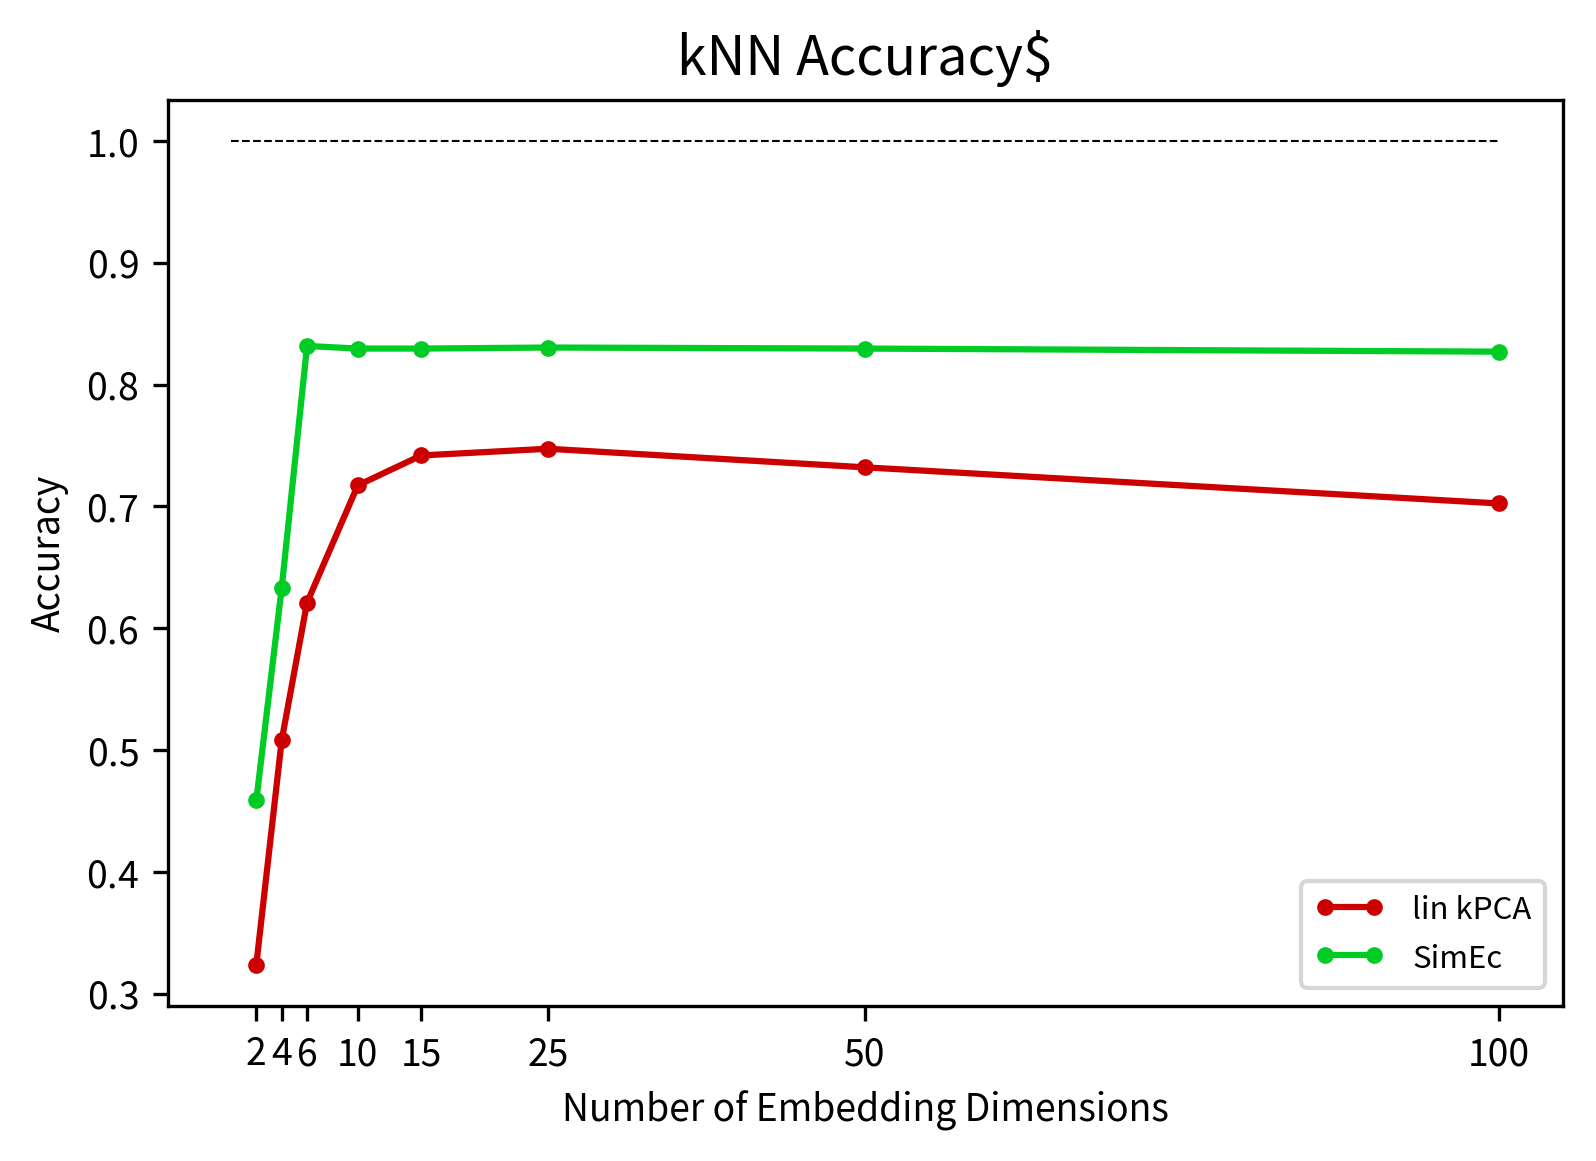

In [40]:
colors = get_colors(10)
acc_pca, acc_simec = [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print e_dim
    e_pca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embedp = e_pca.fit_transform(X)
    X_embedp_test = e_pca.transform(X_test)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embedp, y)
    acc_pca.append(clf.score(X_embedp_test, y_test))
    e_csimenc = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(max(20, e_dim), 'tanh')], 
                                  sparse_inputs=True, s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], 
                                  opt=keras.optimizers.Adamax(lr=0.005))
    e_csimenc.fit(X, S[:,:n_targets])
    X_embed = e_csimenc.transform(X)
    X_embed_test = e_csimenc.transform(X_test)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed, y)
    acc_simec.append(clf.score(X_embed_test, y_test))
    print "acc kpca: %f; acc simec: %f" % (acc_pca[-1], acc_simec[-1])
plt.figure();
plt.plot(e_dims, acc_pca, '-o', markersize=3, c=colors[0], label='lin kPCA');
plt.plot(e_dims, acc_simec, '-o', markersize=3, c=colors[4], label='SimEc');
plt.legend(loc=0);
plt.title('kNN Accuracy$');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions')
plt.ylabel('Accuracy')